In [45]:
import seaborn as sns
import requests
import zipfile
import io
import polars as pl
from matplotlib import pyplot as plt

In [2]:
data_url = "https://foerderdatenbankdump.fra1.cdn.digitaloceanspaces.com/data/data.zip"

In [36]:
response = requests.get(data_url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    file_name = z.namelist()[0]
    with z.open(file_name) as f:
        df = pl.read_parquet(f)

print(f"{len(df)} Förderprogramme")
print(df.columns)
print(df.dtypes)

2505 Förderprogramme
['id_hash', 'id_url', 'url', 'title', 'description', 'more_info', 'legal_basis', 'contact_info_institution', 'contact_info_street', 'contact_info_city', 'contact_info_fax', 'contact_info_phone', 'contact_info_email', 'contact_info_website', 'funding_type', 'funding_area', 'funding_location', 'eligible_applicants', 'funding_body', 'further_links', 'checksum', 'license_info', 'previous_update_dates', 'last_updated']
[String, String, String, String, String, String, String, String, String, String, String, String, String, String, List(String), List(String), List(String), List(String), String, List(String), String, String, List(Datetime(time_unit='us', time_zone=None)), Datetime(time_unit='us', time_zone=None)]


## Descriptive Statistics

### Funding Area

Multiple areas are possible per program

<Axes: xlabel='count'>

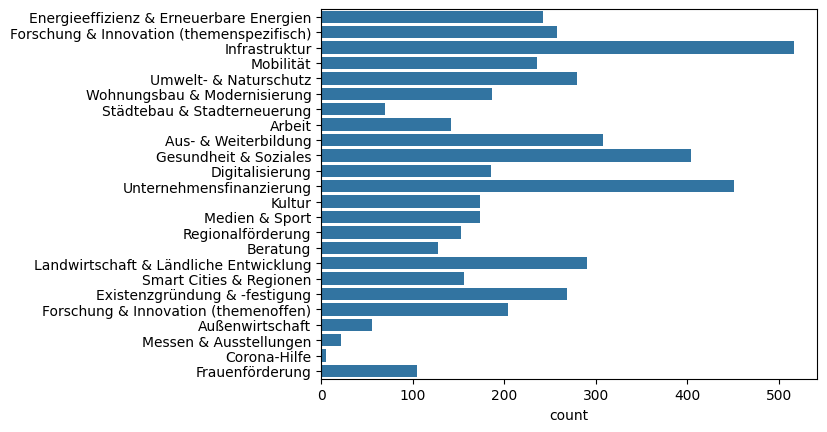

In [30]:
fg_lst = [x for xs in df["funding_area"] if xs is not None for x in xs]
sns.countplot(fg_lst)

### Funding Location

Multiple applicant locations are possible per program.

<Axes: xlabel='count'>

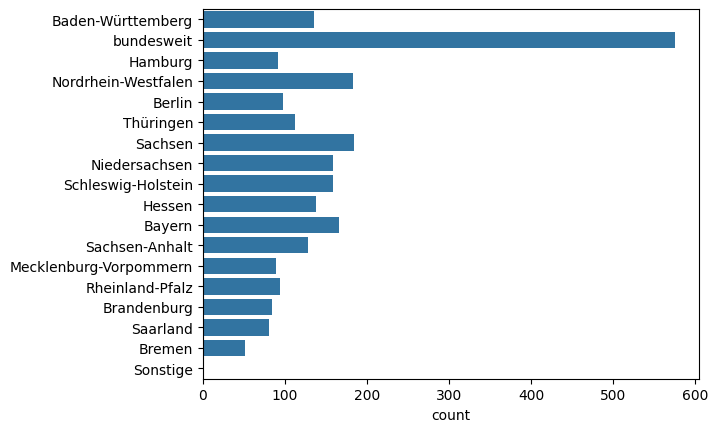

In [31]:
fg_lst = [x for xs in df["funding_location"] if xs is not None for x in xs]
sns.countplot(fg_lst)

### Eligible Applicant Types

Multiple applicant types are possible per program

<Axes: xlabel='count'>

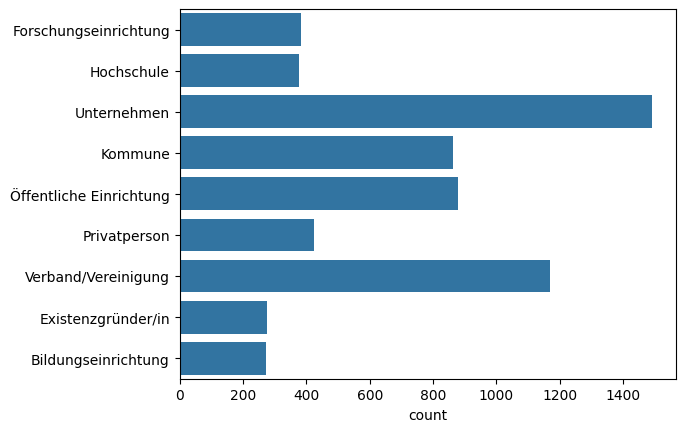

In [34]:
fg_lst = [x for xs in df["eligible_applicants"] if xs is not None for x in xs]
sns.countplot(fg_lst)

### Funding Types
Multiple funding types are possible

<Axes: xlabel='count'>

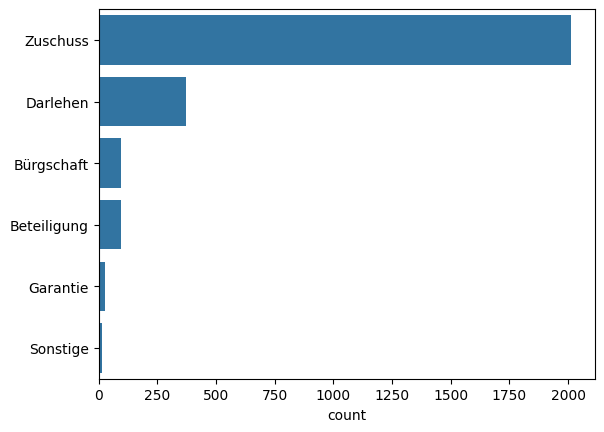

In [35]:
fg_lst = [x for xs in df["funding_type"] if xs is not None for x in xs]
sns.countplot(fg_lst)

## Metadata

### Added Programs

/tmp/ipykernel_44107/2395938706.py:18: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


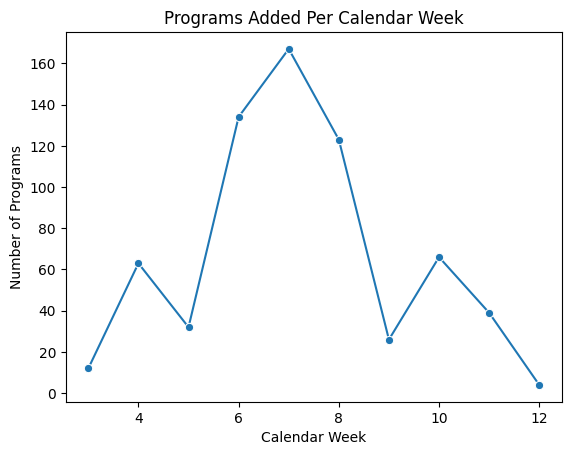

In [68]:

df = df.with_columns(
    pl.when(pl.col("previous_update_dates").is_not_null())
    .then(pl.col("previous_update_dates").list.first())
    .otherwise(pl.col("last_updated"))
    .alias("creation_date")
)

df = df.with_columns(
    pl.col("creation_date").dt.week().alias("week")
)

# filtering first recorded week, because then programs were added initially
first_week = df.select(pl.col("week").min()).to_numpy()[0][0]
df_filtered = df.filter(pl.col("week") != first_week)

weekly_counts = (
    df_filtered.group_by("week")
    .count()
    .rename({"count": "program_count"})  
    .sort("week")
)

sns.lineplot(data=weekly_counts, x="week", y="program_count", marker="o")
plt.title("Programs Added Per Calendar Week")
plt.xlabel("Calendar Week")
plt.ylabel("Number of Programs")
plt.show()